# Gold Price Prediction - Modeling Phase

In [ ]:
'''
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⡠⠴⠒⠒⠲⠤⠤⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡴⠋⠀⠀⠀⠀⠠⢚⣂⡀⠈⠲⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⣀⡀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡎⡴⠆⠀⠀⠀⠀⠀⢎⠐⢟⡇⠀⠈⢣⣠⠞⠉⠉⠑⢄⠀⠀⣰⠋⡯⠗⣚⣉⣓⡄
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣸⢠⢞⠉⡆⠀⠀⠀⠀⠀⠓⠋⠀⠀⠀⠀⢿⠀⠀⠀⠀⠈⢧⠀⢹⣠⠕⠘⢧⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠘⠮⠔⠁⠀⠀⠀⠀⢀⠀⠀⠀⠀⠀⠀⠸⡀⠀⠀⠀⠀⠈⣇⠀⢳⠀⠀⠘⡆⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡴⠋⠉⠓⠦⣧⠀⠀⠀⠀⢦⠤⠤⠖⠋⠇⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠸⡄⠈⡇⠀⠀⢹⡀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠁⠀⠀⠀⠀⠙⡆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠈⣆⠀⠀⠀⢱⠀⡇⠀⠀⠀⡇⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣼⠀⠀⠀⠀⠀⠀⠘⢆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡰⠁⠀⠀⠸⡄⠀⠀⠀⠳⠃⠀⠀⠀⡇⠀
⠀⠀⠀⠀⠀⢠⢏⠉⢳⡀⠀⠀⢹⠀⠀⠀⠀⢠⠀⠀⠀⠑⠤⣄⣀⡀⠀⠀⠀⠀⠀⣀⡤⠚⠀⠀⠀⠀⠀⢸⢢⡀⠀⠀⠀⠀⠀⢰⠁⠀
⠀⠀⣀⣤⡞⠓⠉⠁⠀⢳⠀⠀⢸⠀⠀⠀⠀⢸⡆⠀⠀⠀⠀⠀⠀⠉⠉⠉⠉⠉⠉⠁⠀⠀⠀⠀⠀⠀⠀⢸⠀⠙⠦⣤⣀⣀⡤⠃⠀⠀
⠀⣰⠗⠒⣚⠀⢀⡤⠚⠉⢳⠀⠈⡇⠀⠀⠀⢸⡧⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠸⠵⡾⠋⠉⠉⡏⠀⠀⠀⠈⠣⣀⣳⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠹⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⡼⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠳⡄⠀⠀⠀⠀⠀⠀⠀⡰⠁⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠈⠓⠲⠤⠤⠤⠴⠚⠁⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
'''

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [7]:
# Load Data
df = pd.read_csv("../data/filtered_data.csv", index_col="Date", parse_dates=True)
df = df.ffill()
df.head()

,Gold_Spot,Silver_Fututes,S&P_500,^VIX,USD_Index,CPI,Unemployment,Treasury_Yield_10Y,Real_Interest_Rate,Fed_Funds_Rate,Crude_Oil,GPR,GPRA
Date,,,,,,,,,,,,,
2006-01-31,549.86,9.850,1280.079956,12.950000,99.4311,199.3,4.7,4.42,2.00,4.29,67.919998,94.510017,100.191582
2006-02-28,555.00,9.720,1280.660034,12.340000,99.7695,199.4,4.8,4.57,2.02,4.49,61.410000,95.858192,102.798645
2006-03-31,557.09,11.480,1294.869995,11.390000,100.5600,199.7,4.7,4.72,2.35,4.59,66.629997,92.797623,97.036026
2006-04-28,610.65,13.510,1310.609985,11.590000,98.1412,200.7,4.7,4.99,2.39,4.79,71.879997,89.015800,92.830711
2006-05-31,675.39,12.398,1270.089966,16.440001,97.7705,201.3,4.6,5.11,2.48,4.94,71.290001,85.208778,82.277428


In [8]:
df.columns

Index(['Gold_Spot', 'Silver_Fututes', 'S&P_500', '^VIX', 'USD_Index', 'CPI',
       'Unemployment', 'Treasury_Yield_10Y', 'Real_Interest_Rate',
       'Fed_Funds_Rate', 'Crude_Oil', 'GPR', 'GPRA'],
      dtype='object')

# Linear Regression - Case 1

['Silver_Fututes', 'S&P_500', '^VIX', 'USD_Index', 'CPI', 'Unemployment', 'Treasury_Yield_10Y', 'Real_Interest_Rate', 'Fed_Funds_Rate', 'Crude_Oil', 'GPR', 'GPRA']

=== Testing Feature: Silver_Fututes ===


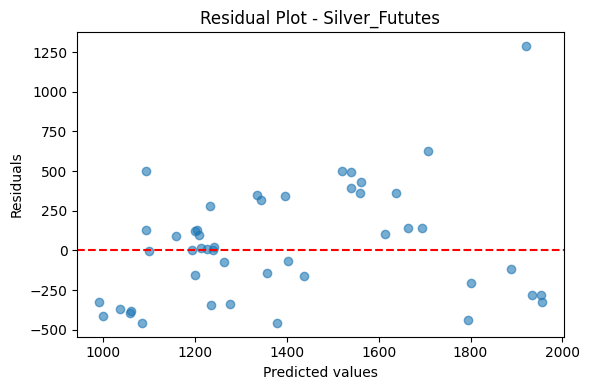


=== Testing Feature: SP500 ===


KeyError: "None of [Index(['SP500'], dtype='object')] are in the [columns]"

In [10]:
# List of features to test (exclude Gold_Spot because it is the target)
feartures = [col for col in df.columns if col != "Gold_Spot"]
print(feartures)

results = []

for feature in features:
    print(f"\n=== Testing Feature: {feature} ===")

    # --- Linear Regression (Case 1) ---
    X = df[[feature]]
    y = df["Gold_Spot"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    y_pred = lin_reg.predict(X_test)

    coef = lin_reg.coef_[0]
    intercept = lin_reg.intercept_

    # --- ANOVA test ---
    model_sm = smf.ols(f'Gold_Spot ~ {feature}', data=df).fit()
    anova_table = sm.stats.anova_lm(model_sm, typ=2)

    f_val = anova_table["F"].iloc[0]
    p_val = anova_table["PR(>F)"].iloc[0]

    # Save results to list
    results.append([feature, coef, intercept, f_val, p_val])

    # --- Residual Plot ---
    residuals = y_test - y_pred
    plt.figure(figsize=(6, 4))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color="r", linestyle="--")
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot - {feature}")
    plt.tight_layout()
    plt.show()


# --- Summary table of results ---
summary_df = pd.DataFrame(
    results, columns=["Feature", "Coefficient", "Intercept", "F-value", "p-value"]
)

print("\n=== Summary of Case 1 (Single Variable Regression) ===")
print(summary_df)

# If running in Jupyter, display the table nicely
display(summary_df)


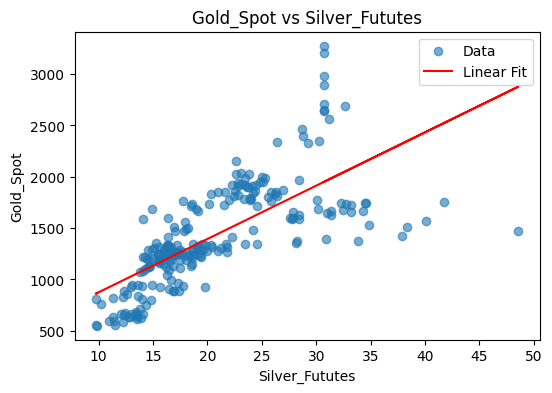

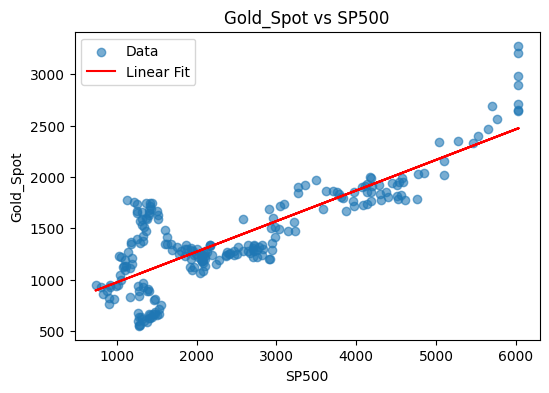

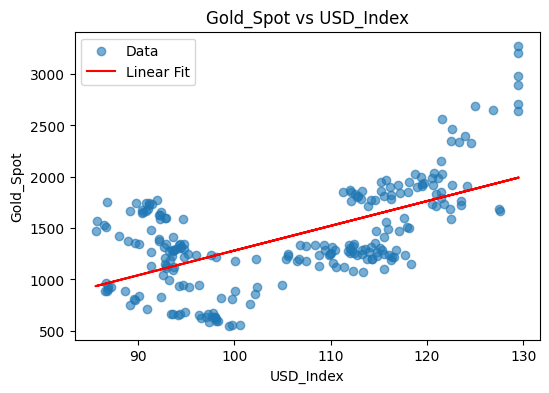

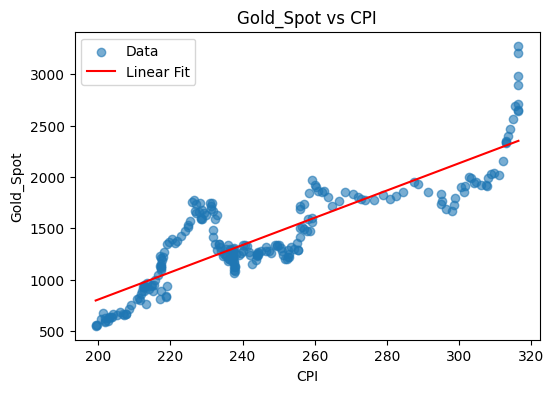

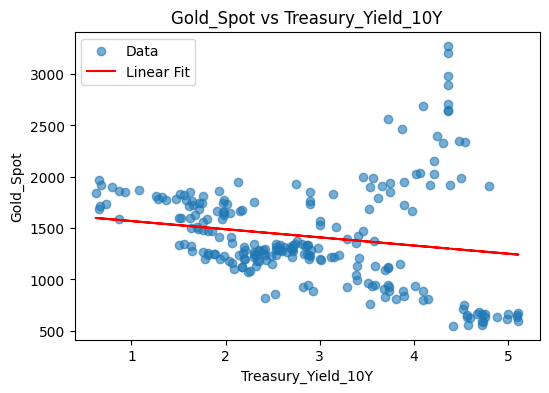

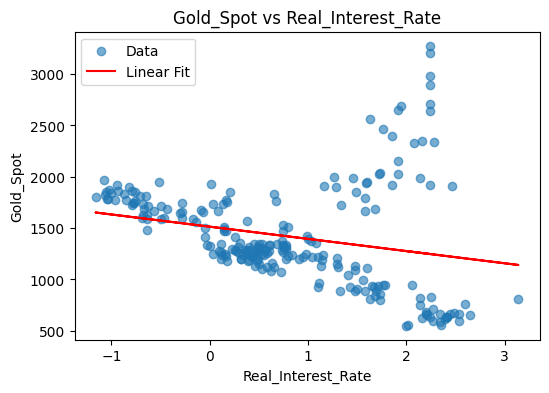

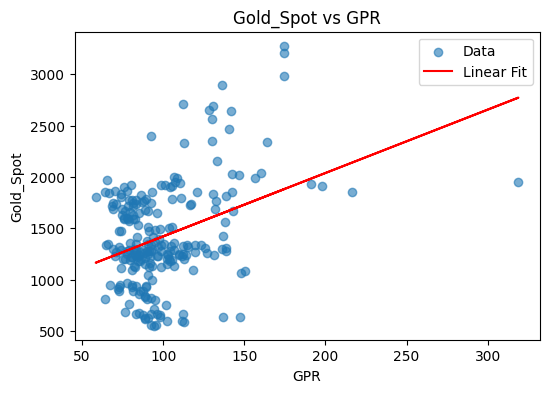

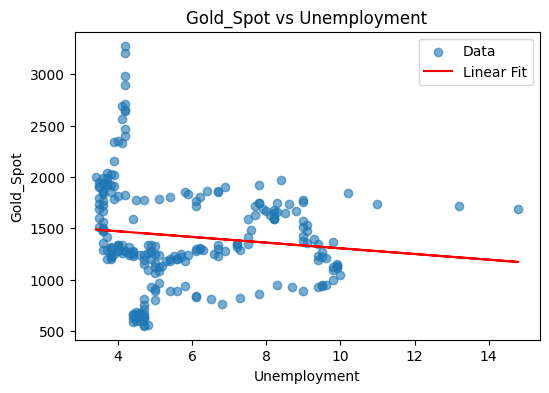

In [ ]:
# Scatter Plot of Gold_Spot with each features
feartures = df.columns.drop("Gold_Spot")

for col in features:
    plt.figure(figsize=(6,4))

    # Scatter plot Gold_Spot vs feature
    plt.scatter(df[col], df["Gold_Spot"], alpha=0.6, label="Data")

    # Fit linear regression line
    m, b = np.polyfit(df[col], df["Gold_Spot"], 1)
    plt.plot(df[col], m*df[col] + b, color="red", label="Linear Fit")

    plt.title(f"Gold_Spot vs {col}")
    plt.xlabel(col)
    plt.ylabel("Gold_Spot")
    plt.legend()
    plt.show()

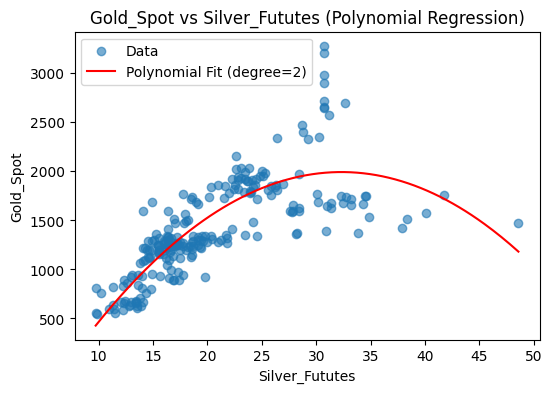

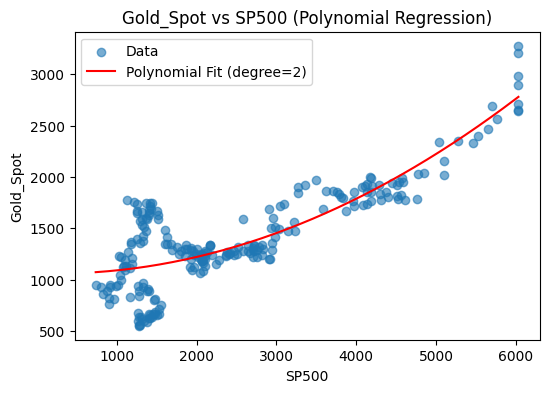

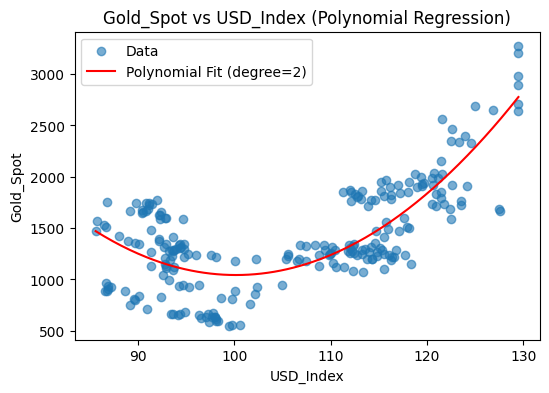

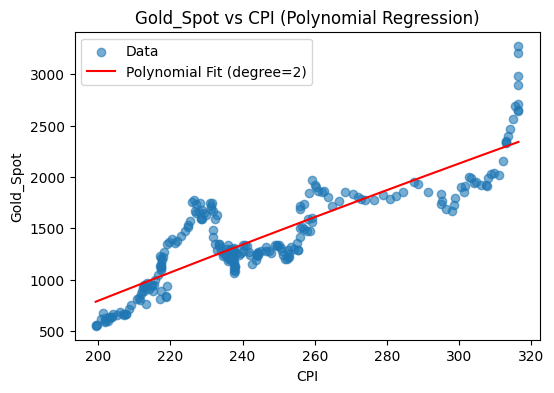

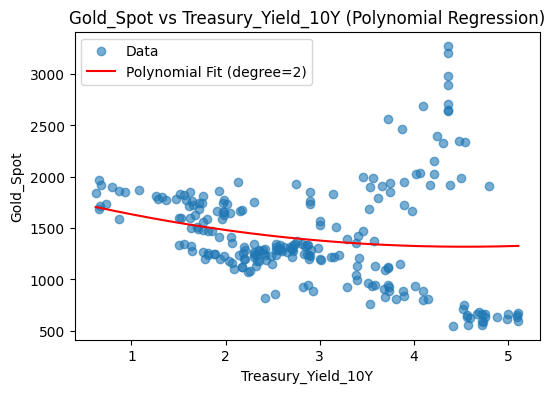

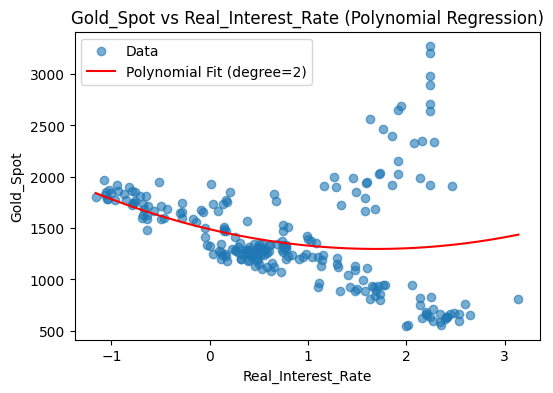

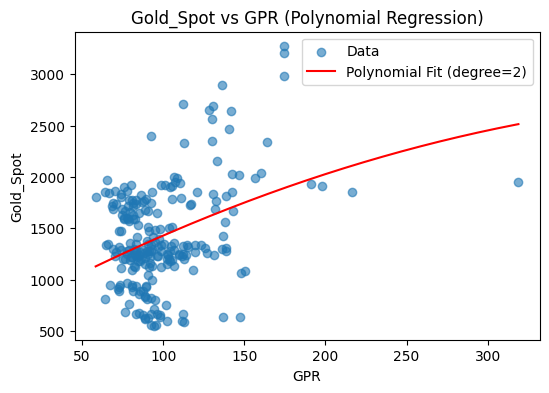

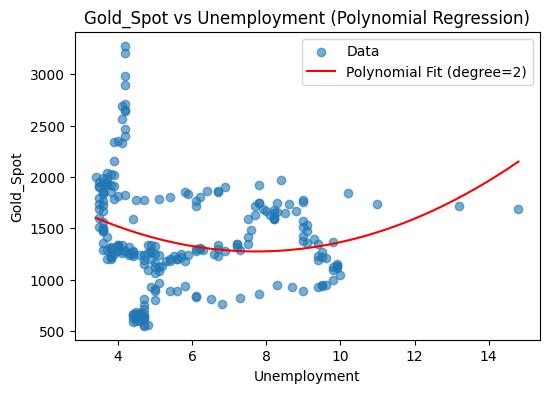

In [49]:
# Polynomial Regression
feartures = [col for col in df.columns if col != "Gold_Spot"]

for col in feartures:
    X = df[[col]].dropna() # ensure no NaN values
    y = df.loc[X.index, "Gold_Spot"] # align index with target


    # Create polynomial features of degree 2
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X)

    # Fit the model
    model = LinearRegression()
    model.fit(X_poly, y)

    # Generate smooth curve data for plotting
    X_sorted = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
    X_sorted = pd.DataFrame(X_sorted, columns=[col])
    X_sorted_poly = poly.transform(X_sorted)
    y_pred = model.predict(X_sorted_poly)

    # Plot scatter + polynomial fit curve
    plt.figure(figsize=(6,4))
    plt.scatter(X, y, alpha=0.6, label="Data")
    plt.plot(X_sorted, y_pred, color="red", label="Polynomial Fit (degree=2)")
    plt.title(f"Gold_Spot vs {col} (Polynomial Regression)")
    plt.xlabel(col)
    plt.ylabel("Gold_Spot")
    plt.legend()
    plt.show()
